<div style="border-radius: 15px; border: 2px solid #2e8b57; padding: 20px; background-color: #b9fbc0; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); font-family: sans-serif;">

  <div style="text-align: center; margin-bottom: 20px;">
    <img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="300" alt="Logo FIUBA">
  </div>

  <h1 style="color: #2e8b57; text-align: center; text-shadow: 1px 1px 3px rgba(0,0,0,0.3); font-size: 28px; margin-bottom: 10px;">
    TRABAJO FINAL INTEGRADOR
  </h1>

  <div style="text-align: center;">
    <h2 style="color: #2e8b57; margin: 0; font-weight: normal;">VISIÓN POR COMPUTADORA II</h2>
    <h3 style="color: #2e8b57; margin-top: 5px; margin-bottom: 20px; font-weight: normal;">Chest CT-Scan images Dataset 2025</h3>
  </div>

  <hr style="border: none; height: 2px; background-color: #2e8b57; margin: 20px 0;">

  <div style="color: #004d40; font-size: 16px; font-weight: bold; margin-bottom: 5px;">ALUMNOS:</div>
  <ul style="color: #004d40; font-size: 16px; margin-top: 0; padding-left: 20px;">
    <li>Mauro Fabian Barquinero</li>
    <li>Juan Cruz Ojeda</li>
    <li>Mariano Campos</li>
    <li>Jose Luis Perez Galindo</li>
  </ul>

  <hr style="border: none; height: 1px; background-color: #2e8b57; margin: 20px 0;">

  <div style="text-align: center;">
    <a href="https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images" target="_blank"
       style="background-color: #2e8b57; color: white; padding: 10px 20px; text-decoration: none; border-radius: 8px; box-shadow: 1px 1px 4px rgba(0,0,0,0.3); font-weight: bold; display: inline-block;">
      ENLACE DATASET
    </a>
  </div>

</div>



<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Descripción del problema</h1>
</div>


El presente trabajo se enfoca en la detección automática de nódulos pulmonares a partir de imágenes de tomografía computada (CT) de tórax. Esta problemática reviste gran importancia en contextos clínicos, donde un diagnóstico temprano puede mejorar significativamente el pronóstico de los pacientes. Dado el carácter médico de las imágenes, se requiere especial atención en el preprocesamiento y en la selección del modelo, priorizando el *recall* sobre otras métricas para evitar falsos negativos.

## Cargar bibliotecas

In [32]:
# Librerías estándar de Python
import os
import shutil
import zipfile
from pathlib import Path
from collections import defaultdict

# Procesamiento de datos y visualización
import numpy as np           # Operaciones numéricas
import pandas as pd          # Manipulación de dataframes
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns            # Visualización estadística
from PIL import Image            # Manejo de imágenes

# OpenCV para procesamiento de imágenes
import cv2                      # Visión por computadora tradicional

# Scikit-learn para machine learning tradicional
from sklearn.ensemble import RandomForestClassifier  # Clasificador clásico
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # Optimización de hiperparámetros
from sklearn.preprocessing import LabelEncoder       # Codificación de etiquetas
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer  # Métricas

# Utilidades adicionales
from tqdm import tqdm         # Barra de progreso
import joblib                 # Guardado y carga de modelos

# Semilla para reproducibilidad de los experimentos
np.random.seed(42)


---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Análisis de la estructura del dataset</h1>
</div>

## Verificar las carpetas del dataset

In [33]:
# Descomprimir archive.zip en el directorio actual (si existe)
if os.path.exists("archive.zip"):
    with zipfile.ZipFile("archive.zip", "r") as zip_ref:
        zip_ref.extractall(".")


# Path del directorio
data_dir = os.path.join(".", "Data")

# Verificamos que el directorio exista
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"No se encontró el directorio: {data_dir}")

# Listar las clases dentro de cada subconjunto: train, test y valid
subsets = ['train', 'test', 'valid']

for subset in subsets:
    subset_path = os.path.join(data_dir, subset)
    if not os.path.exists(subset_path):
        print(f"[ADVERTENCIA] No se encontró el subdirectorio: {subset_path}")
        continue
    classes = os.listdir(subset_path)
    print(f"\n{subset.upper()}:")
    for cls in classes:
        print(f"  - {cls}")


TRAIN:
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
  - normal
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa

TEST:
  - adenocarcinoma
  - large.cell.carcinoma
  - normal
  - squamous.cell.carcinoma

VALID:
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
  - normal
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


---

Como podemos observar, los nombres de las carpetas correspondientes a los subtipos de cáncer presentan inconsistencias significativas. Mientras que en los conjuntos `TRAIN` y `VALID` se utilizan nombres extensos que incluyen información anatómica y estadios clínicos (por ejemplo, `adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib`), en `TEST` los nombres aparecen abreviados o truncados (por ejemplo, `adenocarcinoma`, `large.cell.carcinoma`).

Esta disparidad genera múltiples inconvenientes:

- Dificulta la unificación de clases al momento de entrenar modelos de clasificación.
- Puede inducir a errores en el proceso de etiquetado o evaluación si no se realiza un mapeo previo.
- Aumenta el riesgo de duplicación o fragmentación de clases al momento de vectorizar los datos.

Por lo tanto, resulta fundamental estandarizar la nomenclatura de las clases. Una estrategia posible consiste en mapear todos los nombres detallados a una versión abreviada y uniforme, tal como:

- `adenocarcinoma`
- `large.cell.carcinoma`
- `squamous.cell.carcinoma`
- `normal`

Este paso de limpieza debe realizarse antes de cualquier proceso de entrenamiento para garantizar la coherencia en los datos y evitar sesgos o errores de clasificación.

---


 ## Visualizar las imágenes por clases.


📂 train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib:


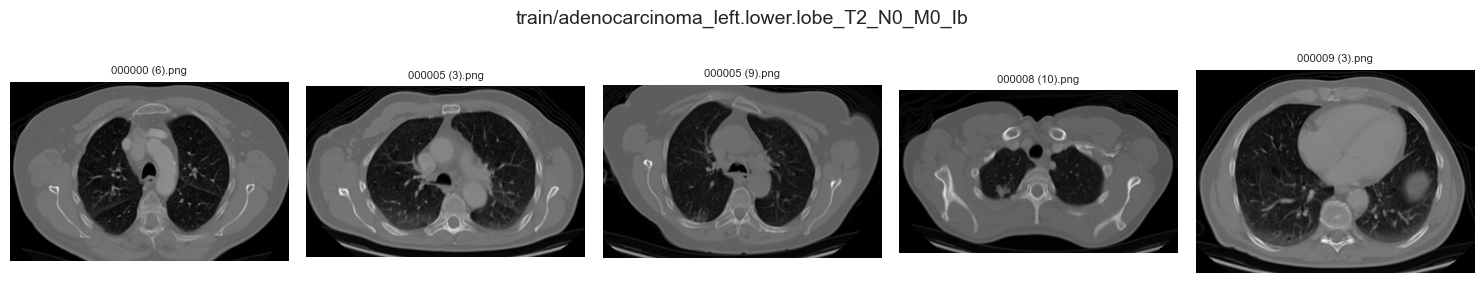


📂 train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa:


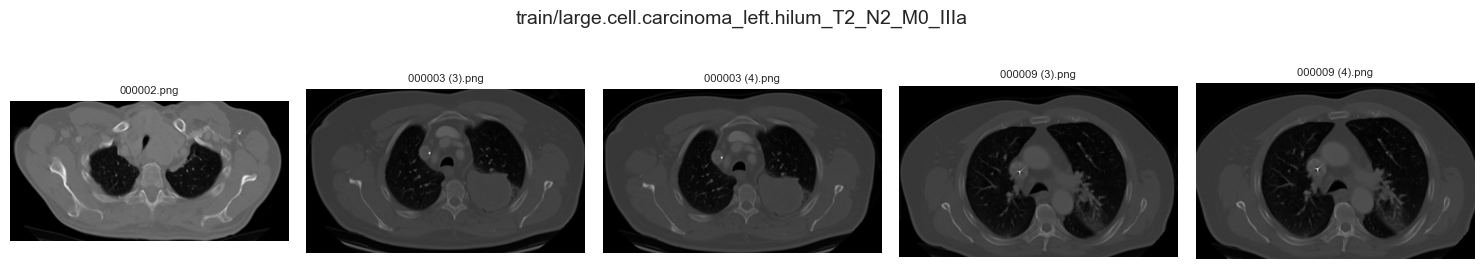


📂 train/normal:


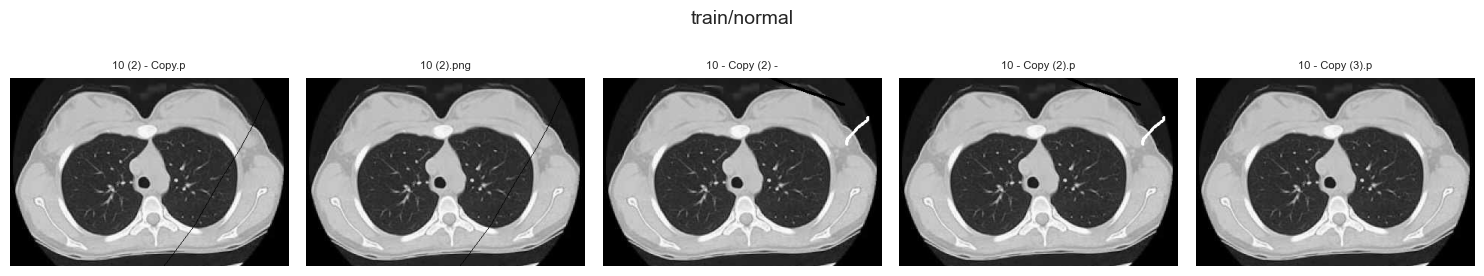


📂 train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa:


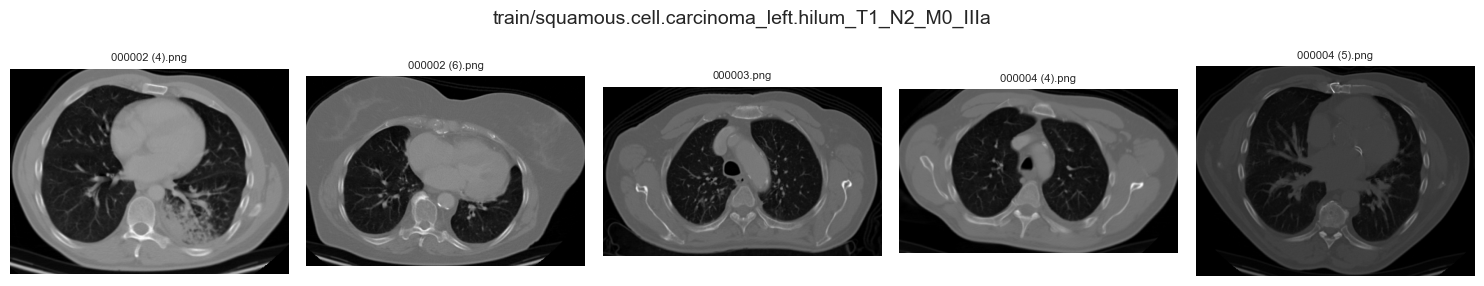


📂 valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib:


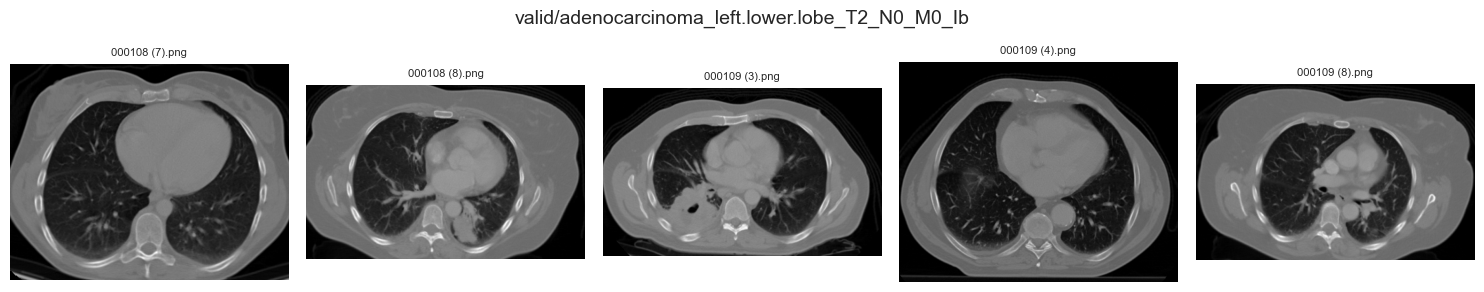


📂 valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa:


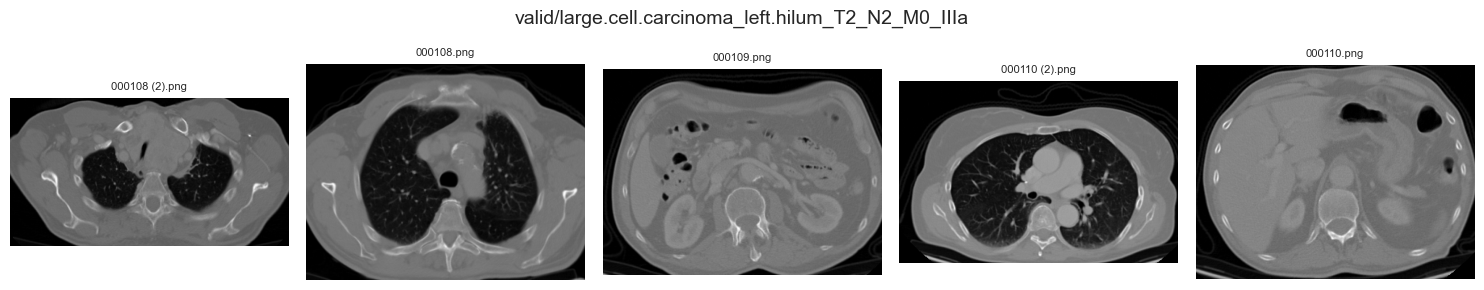


📂 valid/normal:


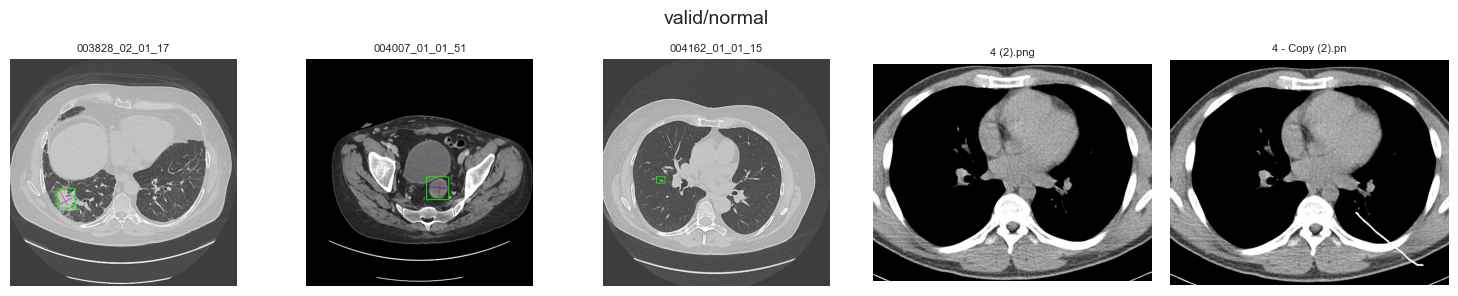


📂 valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa:


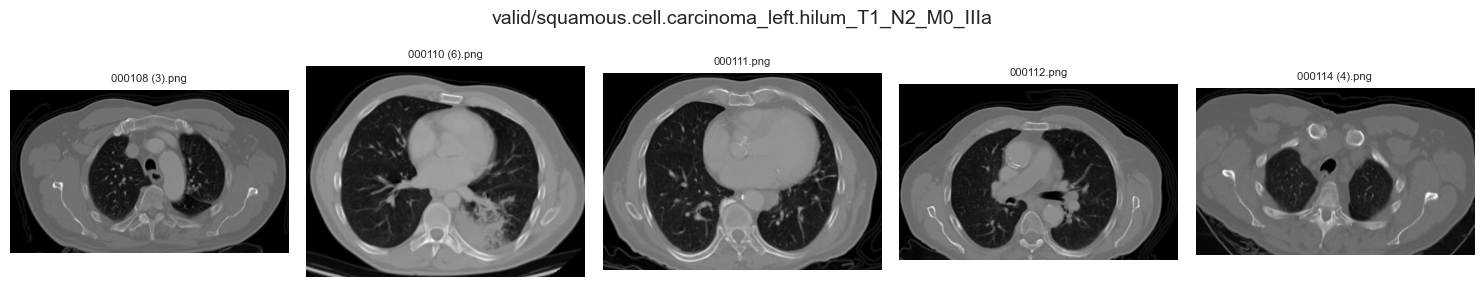


📂 test/adenocarcinoma:


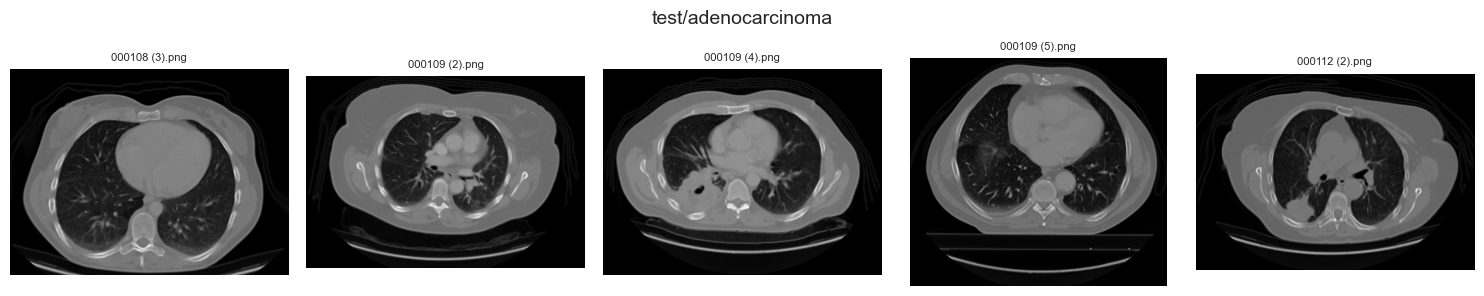


📂 test/large.cell.carcinoma:


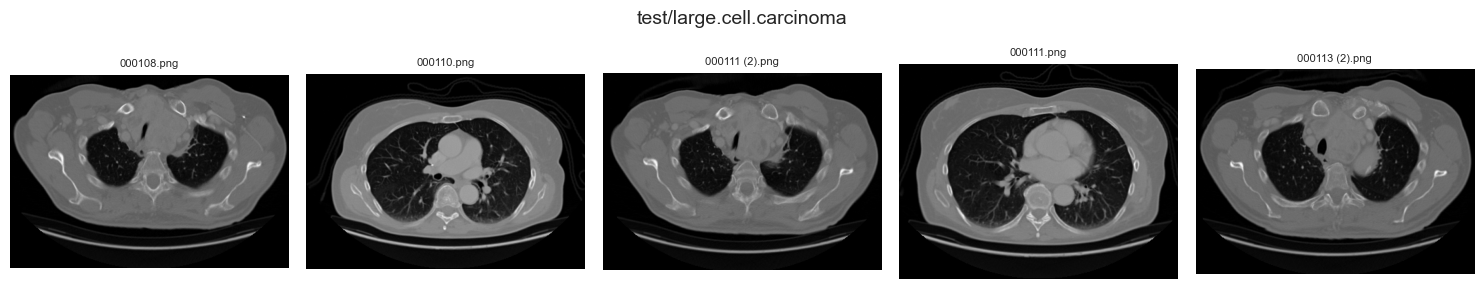


📂 test/normal:


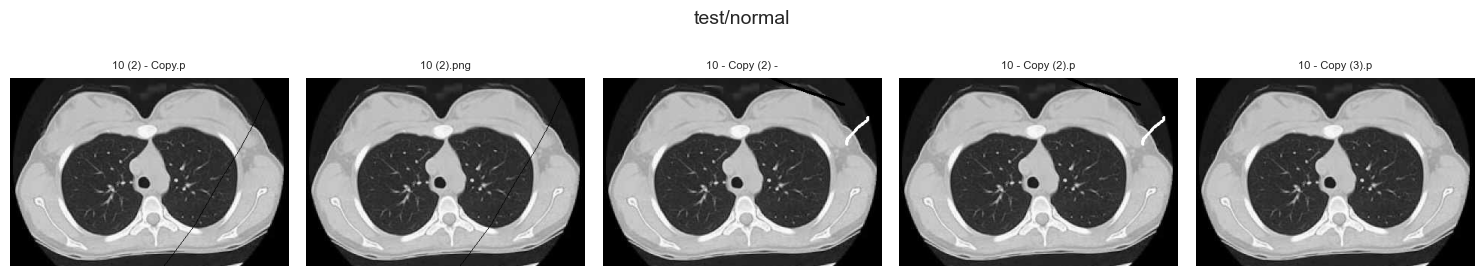


📂 test/squamous.cell.carcinoma:


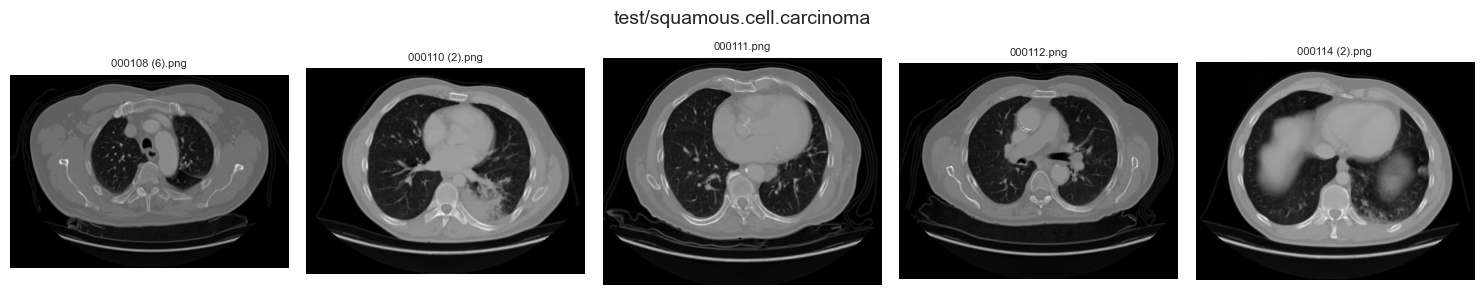

In [34]:
dataset_root = Path("./Data")

# Función para mostrar imágenes por subcarpeta sin importar el label
def mostrar_5_imagenes_por_subcarpeta(data_dir, subsets=["train", "valid", "test"]):
    for subset in subsets:
        subset_path = Path(data_dir) / subset
        if not subset_path.exists():
            print(f"[ADVERTENCIA] No existe el directorio {subset_path}")
            continue

        subfolders = [f for f in subset_path.iterdir() if f.is_dir()]
        for subfolder in subfolders:
            image_files = sorted([f for f in subfolder.iterdir() if f.is_file()])[:5]
            if not image_files:
                continue

            print(f"\n📂 {subset}/{subfolder.name}:")
            fig, axes = plt.subplots(1, len(image_files), figsize=(3 * len(image_files), 3))
            fig.suptitle(f"{subset}/{subfolder.name}", fontsize=14)

            if len(image_files) == 1:
                axes = [axes]

            for i, img_path in enumerate(image_files):
                img = cv2.imread(str(img_path))
                if img is None:
                    axes[i].axis("off")
                    axes[i].set_title("Error de lectura", fontsize=8)
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
                axes[i].axis("off")
                axes[i].set_title(img_path.name[:15], fontsize=8)

            plt.tight_layout()
            plt.show()

# Ejecutar la función
mostrar_5_imagenes_por_subcarpeta(dataset_root)

---

Se realizó una inspección sobre las imágenes del dataset y se pudo constatar que, en el caso de los distintos tipos de cáncer, no existen duplicados. Las imágenes que comparten el mismo identificador numérico corresponden al mismo estudio torácico, pero capturado desde diferentes cortes o ángulos. Esta diversidad de vistas permite una mejor visualización y análisis de la enfermedad desde distintas perspectivas.

Durante el análisis también se detectaron imágenes con nombres similares (como aquellas que contienen copy o (2)), especialmente en la clase normal. Aunque algunas pueden parecer duplicadas, presentan pequeñas diferencias como anotaciones, marcas o variaciones de contraste. Estas diferencias enriquecen el conjunto de datos con ejemplos más realistas, por lo que se decidió conservar todas las imágenes.

A continuación se presentan dos ejemplos representativos de esta situación.

---

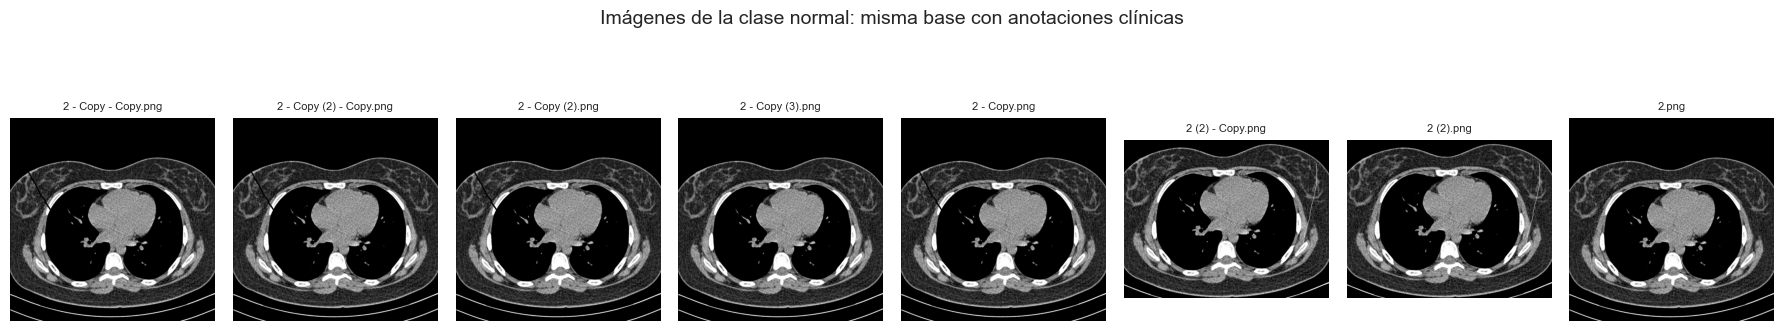

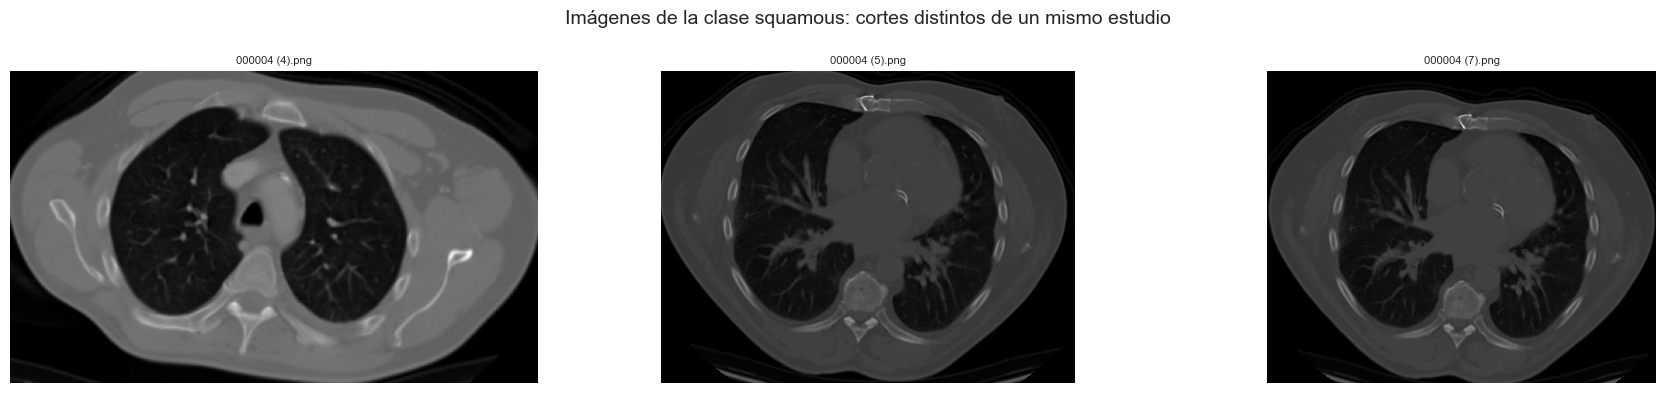

In [35]:
def mostrar_imagenes_por_nombres(ruta_clase, nombres_archivos, titulo_fila):
    fig, axes = plt.subplots(1, len(nombres_archivos), figsize=(18, 4))
    fig.suptitle(titulo_fila, fontsize=14)

    for ax, nombre in zip(axes, nombres_archivos):
        ruta_img = Path(ruta_clase) / nombre
        with Image.open(ruta_img) as img:
            ax.imshow(img, cmap='gray')
            ax.set_title(nombre, fontsize=8)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Carpeta base
base_path = "Data/train"

# Imágenes de la clase 'normal'
imagenes_normal = [
    "2 - Copy - Copy.png",
    "2 - Copy (2) - Copy.png",
    "2 - Copy (2).png",
    "2 - Copy (3).png",
    "2 - Copy.png",
    "2 (2) - Copy.png",
    "2 (2).png",
    "2.png"
]
mostrar_imagenes_por_nombres(
    ruta_clase=f"{base_path}/normal",
    nombres_archivos=imagenes_normal,
    titulo_fila="Imágenes de la clase normal: misma base con anotaciones clínicas"
)

# Imágenes de la clase 'squamous'
imagenes_squamous = [
    "000004 (4).png",
    "000004 (5).png",
    "000004 (7).png"
]

base_path = Path(base_path) 

# Opciones de carpeta posibles
carpetas_opcionales = [
    "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa",
    "squamous.cell.carcinoma"
]

# Buscar la primera carpeta existente
ruta_clase = None
for nombre in carpetas_opcionales:
    posible_ruta = base_path / nombre
    if posible_ruta.exists():
        ruta_clase = posible_ruta
        break

if ruta_clase is None:
    print("No se encontró ninguna de las carpetas esperadas.")
else:
    mostrar_imagenes_por_nombres(
        ruta_clase=ruta_clase,
        nombres_archivos=imagenes_squamous,
        titulo_fila="Imágenes de la clase squamous: cortes distintos de un mismo estudio"
    )


---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Limpieza</h1>
</div>

> **Nota:**  
> Como se observó, los nombres de las carpetas correspondientes a los subtipos de cáncer presentan inconsistencias significativas entre los conjuntos de datos. Este tipo de disparidades no solo dificulta el procesamiento automatizado, sino que también puede inducir errores en la interpretación de etiquetas.  
> 
> Por ello, resulta fundamental realizar una estandarización previa a cualquier tarea de entrenamiento. La adopción de una nomenclatura uniforme no solo facilita la manipulación de los datos, sino que además asegura la coherencia semántica entre las clases utilizadas para el aprendizaje del modelo.


## Se procede a generalizar los nombres de las carpetas

In [36]:
# Definir etiquetas válidas
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Función para encontrar el nombre de etiqueta a partir del nombre de carpeta
def find_label_from_folder(folder_name, labels):
    for label in labels:
        if folder_name.startswith(label):
            return label
    return None

# Particiones donde renombrar carpetas
splits_to_fix = ["train", "valid"]
base_path = os.path.join(".", "Data")

# Renombrar carpetas
for split in splits_to_fix:
    split_path = os.path.join(base_path, split)
    for folder_name in os.listdir(split_path):
        full_path = os.path.join(split_path, folder_name)
        if not os.path.isdir(full_path):
            continue
        label = find_label_from_folder(folder_name, labels)
        if label and folder_name != label:
            new_path = os.path.join(split_path, label)
            if not os.path.exists(new_path):
                shutil.move(full_path, new_path)
            else:
                # Si ya existe, mover los archivos a la carpeta correcta y eliminar la original
                for file in os.listdir(full_path):
                    shutil.move(os.path.join(full_path, file), os.path.join(new_path, file))
                os.rmdir(full_path)

# Verificamos la nueva estructura
fixed_structure = {}
for split in splits_to_fix:
    split_path = os.path.join(base_path, split)
    fixed_structure[split] = sorted(os.listdir(split_path))

fixed_structure

{'train': ['adenocarcinoma',
  'large.cell.carcinoma',
  'normal',
  'squamous.cell.carcinoma'],
 'valid': ['adenocarcinoma',
  'large.cell.carcinoma',
  'normal',
  'squamous.cell.carcinoma']}

---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Análisis estadísticos</h1>
</div>

## Tamaños de las imágenes del dataset.

In [37]:
splits = ["train", "valid", "test"]
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


def obtener_dimensiones_imagenes(dataset_root, splits, labels, max_imgs=4):
    dimensiones = []

    for split in splits:
        for label in labels:
            folder = dataset_root / split / label
            if not folder.exists():
                continue
            image_files = sorted([f for f in folder.iterdir() if f.is_file()])

            #image_files = sorted([f for f in folder.iterdir() if f.is_file()])[:max_imgs]
            for img_path in image_files:
                img = cv2.imread(str(img_path))
                if img is not None:
                    dimensiones.append((split, label, img.shape[0], img.shape[1]))  # alto, ancho

    return dimensiones

# Obtener dimensiones
dims = obtener_dimensiones_imagenes(dataset_root, splits, labels)

# 1. Convertir la lista a DataFrame
df_dims = pd.DataFrame(dims, columns=["split", "label", "height", "width"])

# Calcular relación de aspecto (ancho / alto)
df_dims["aspect_ratio"] = df_dims["width"] / df_dims["height"]

# 2. Agrupar y ocultar el contador (sin eliminar filas)
df_dims_grouped = df_dims.groupby(["split", "label", "height", "width"]).size().reset_index()

# 3. Ocultar la columna del contador (la última)
df_dims_grouped = df_dims_grouped.iloc[:, :-1]

# 4. Mostrar
df_dims_grouped

,split,label,height,width
0,test,adenocarcinoma,260,439
1,test,adenocarcinoma,262,385
2,test,adenocarcinoma,264,484
3,test,adenocarcinoma,271,400
4,test,adenocarcinoma,273,501
...,...,...,...,...
830,valid,squamous.cell.carcinoma,266,379
831,valid,squamous.cell.carcinoma,271,440
832,valid,squamous.cell.carcinoma,284,438
833,valid,squamous.cell.carcinoma,295,378


## Distribuciones de los tamaños de las imágenes del dataset.

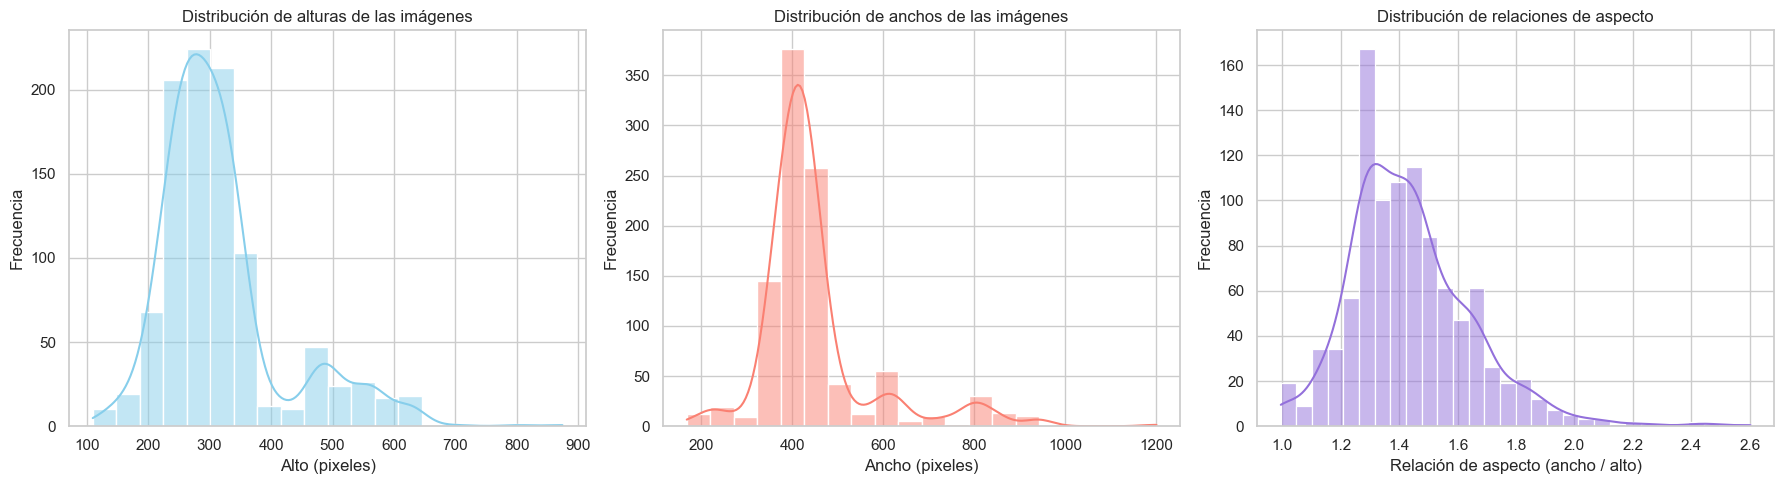

In [38]:
# Estilo general
sns.set(style="whitegrid")

# Crear figura con dos subgráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de alturas
sns.histplot(data=df_dims, x="height", bins=20, kde=True, ax=axs[0], color="skyblue")
axs[0].set_title("Distribución de alturas de las imágenes")
axs[0].set_xlabel("Alto (pixeles)")
axs[0].set_ylabel("Frecuencia")

# Histograma de anchos
sns.histplot(data=df_dims, x="width", bins=20, kde=True, ax=axs[1], color="salmon")
axs[1].set_title("Distribución de anchos de las imágenes")
axs[1].set_xlabel("Ancho (pixeles)")
axs[1].set_ylabel("Frecuencia")

# Graficar histograma
sns.histplot(data=df_dims, x="aspect_ratio", bins=30, kde=True, color="mediumpurple")
axs[2].set_title("Distribución de relaciones de aspecto")
axs[2].set_xlabel("Relación de aspecto (ancho / alto)")
axs[2].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


---

Se analizaron las dimensiones (alto y ancho) de todas las imágenes de los subconjuntos `train`, `valid` y `test` con el objetivo de caracterizar la variabilidad presente en el dataset.

Se presentan a continuación tres histogramas que reflejan la distribución de:

- Alturas (en píxeles)
- Anchos (en píxeles)
- Relaciones de aspecto (ancho / alto)

Las distribuciones de alto y ancho evidencian una concentración de valores entre 250–350 px de alto y 350–500 px de ancho, con algunos valores atípicos en los extremos.

Dado que las imágenes presentan tamaños heterogéneos, **es necesario redimensionarlas a una resolución unificada**

En cuanto a la relación de aspecto, se observa una distribución centrada aproximadamente en 1.4, con una dispersión moderada. Esto indica que la mayoría de las imágenes tienen proporciones similares, por lo que **es conveniente conservar dicha proporción durante el redimensionamiento**

---

## Histograma de intensidades por clase

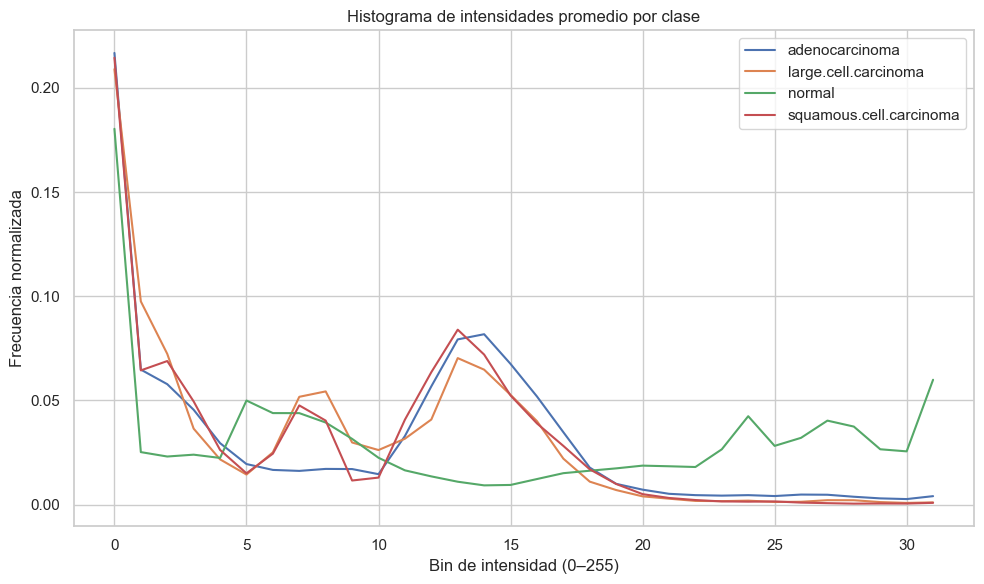

In [39]:
def obtener_histogramas(dataset_root, splits, labels, bins=32):
    hist_por_clase = {label: [] for label in labels}

    for split in splits:
        for label in labels:
            folder = dataset_root / split / label
            if not folder.exists():
                continue
            image_files = sorted([f for f in folder.iterdir() if f.is_file()])
            for img_path in image_files:
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
                    hist = hist.flatten() / hist.sum()  # normalizar
                    hist_por_clase[label].append(hist)

    # Calcular histograma promedio por clase
    hist_promedios = {
        label: np.mean(hist_por_clase[label], axis=0) for label in labels
    }

    return hist_promedios

# Calcular
hist_prom = obtener_histogramas(dataset_root, splits, labels, bins=32)

# Graficar
plt.figure(figsize=(10, 6))
for label, hist in hist_prom.items():
    plt.plot(hist, label=label)

plt.title("Histograma de intensidades promedio por clase")
plt.xlabel("Bin de intensidad (0–255)")
plt.ylabel("Frecuencia normalizada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---

Se calcularon histogramas de intensidad promedio para cada clase, dividiendo el rango tonal [0–255] en 32 intervalos (bins). Esta visualización permite comparar las distribuciones de niveles de gris presentes en las imágenes.

Los resultados muestran que todas las clases presentan una gran concentración de valores en los bins más bajos, reflejando la presencia dominante de fondo negro. No obstante, se observan diferencias:

- La clase **normal** presenta mayor proporción de valores altos, lo cual puede deberse a una delimitación más clara entre pulmón y fondo.
- Las clases cancerosas muestran una mayor proporción de intensidades intermedias, posiblemente asociadas a regiones de masa o tejido afectado.
- La forma general de los histogramas varía sutilmente entre clases, lo que indica que **la distribución de intensidades es una fuente potencial de discriminación** entre ellas.

Estas diferencias refuerzan la utilidad de incluir histogramas de intensidad como parte de las features del modelo tradicional.

---


## Análisis del balance de clases

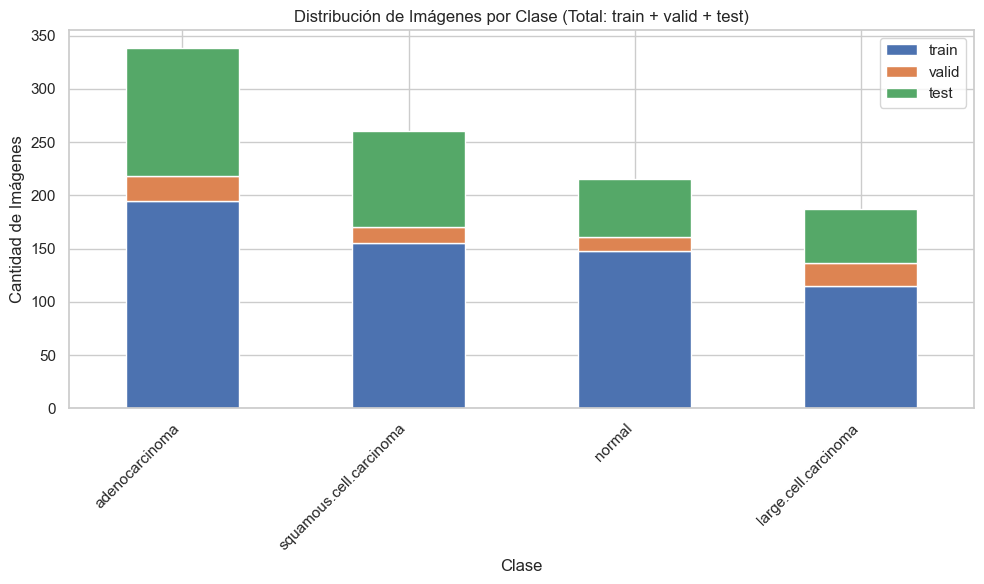

,train,valid,test,total
adenocarcinoma,195,23,120,338
squamous.cell.carcinoma,155,15,90,260
normal,148,13,54,215
large.cell.carcinoma,115,21,51,187


In [40]:
subsets = ["train", "valid", "test"]
class_distribution = defaultdict(lambda: {"train": 0, "valid": 0, "test": 0})

for subset in subsets:
    subset_path = os.path.join(dataset_root, subset)
    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_distribution[class_name][subset] = count

# Convertir a DataFrame
df_balance = pd.DataFrame(class_distribution).T.fillna(0).astype(int)
df_balance["total"] = df_balance.sum(axis=1)
df_balance = df_balance.sort_values("total", ascending=False)

# Graficar
df_balance[["train", "valid", "test"]].plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Distribución de Imágenes por Clase (Total: train + valid + test)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Mostrar tabla
df_balance

---

Análisis de la distribución de clases

- El conjunto de datos presenta un desbalance moderado entre clases:
  - Adenocarcinoma (`338` imágenes) es la clase con mayor cantidad total de muestras.
  - Le siguen Squamous cell carcinoma (`260`) y Normal (`215`).
  - Large cell carcinoma (`187`) es la clase con menor representación.

- Aunque el conjunto `train` mantiene una distribución relativamente balanceada entre clases, las diferencias se amplifican al considerar la suma total (`train` + `valid` + `test`), lo cual podría impactar negativamente en el rendimiento del modelo sobre clases con menor representación.

---

## Diagrama de caja y bigote de la intensidad media por clase

Estadísticas de Intensidad y Tamaños por Clase:

                           mean    std  min  max   width  height
class                                                           
adenocarcinoma            82.60  54.65    0  255  385.57  258.27
large.cell.carcinoma      62.47  46.51    0  255  398.53  259.74
normal                   113.89  80.51    0  255  572.24  429.97
squamous.cell.carcinoma   66.72  46.33    0  255  396.50  271.38


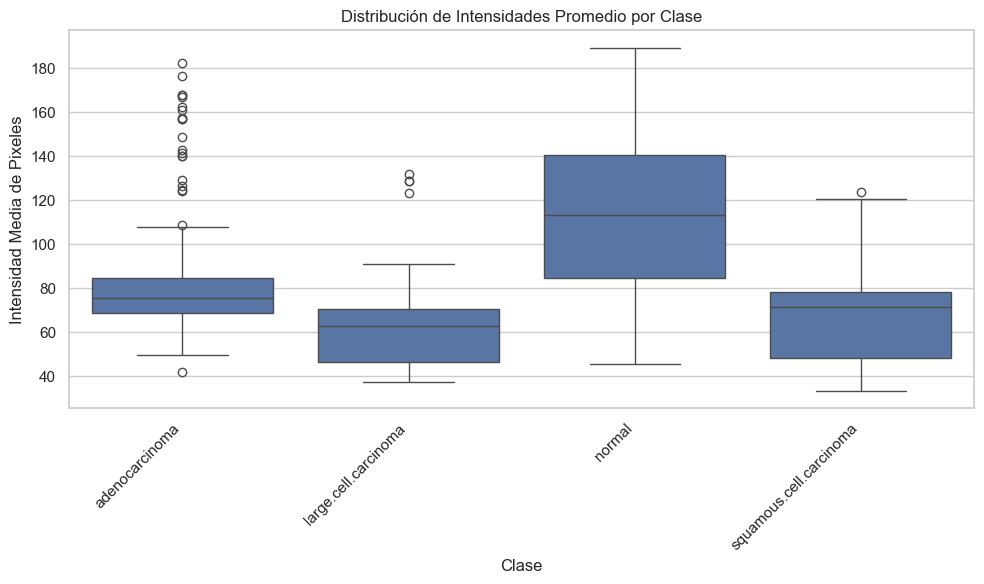

In [41]:
# Analizar dimensiones y estadísticas de intensidad por clase
image_shapes = []
intensity_stats = []

# Vamos a recorrer sólo el conjunto de entrenamiento (train) para este análisis
subset = "train"
subset_path = os.path.join(".", "Data", subset)

for class_name in os.listdir(subset_path):
    class_path = os.path.join(subset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).convert("L")  # Escala de grises
            img_array = np.array(img)

            # Guardar dimensiones
            image_shapes.append(img_array.shape)

            # Guardar estadísticas
            intensity_stats.append({
                "class": class_name,
                "mean": img_array.mean(),
                "std": img_array.std(),
                "min": img_array.min(),
                "max": img_array.max(),
                "width": img_array.shape[1],
                "height": img_array.shape[0]
            })

# Convertir a DataFrame
intensity_df = pd.DataFrame(intensity_stats)
# Agrupamos por clase y mostramos estadísticos promedio
summary_df = intensity_df.groupby("class").agg({
    "mean": "mean",
    "std": "mean",
    "min": "min",
    "max": "max",
    "width": "mean",
    "height": "mean"
}).round(2)

# Mostrar el resultado
print("Estadísticas de Intensidad y Tamaños por Clase:\n")
print(summary_df)

selected_classes = intensity_df['class'].unique()

# Crear histograma de intensidades promedio por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=intensity_df, x="class", y="mean")
plt.title("Distribución de Intensidades Promedio por Clase")
plt.ylabel("Intensidad Media de Pixeles")
plt.xlabel("Clase")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

---

El gráfico de cajas muestra la distribución de la intensidad promedio de píxeles por clase en el conjunto de entrenamiento:

- Normal: Tiene las intensidades más altas (mediana > 110), con una amplia dispersión y varios valores atípicos por encima de 180. Esto indica una mayor luminosidad general en pulmones sanos.
- Adenocarcinoma y Squamous cell carcinoma: Presentan medianas entre 70 y 80, con distribución más compacta. Reflejan menor brillo debido a la presencia de masas o lesiones.
- Large cell carcinoma: Es la clase con menor intensidad media (mediana < 70), lo que podría asociarse a imágenes más oscuras o tumores densos.

La intensidad promedio puede ser un buen descriptor para distinguir entre imágenes normales y patológicas, aunque entre subtipos de cáncer hay solapamientos.

---

## Análisis de la desviación estándar por clase

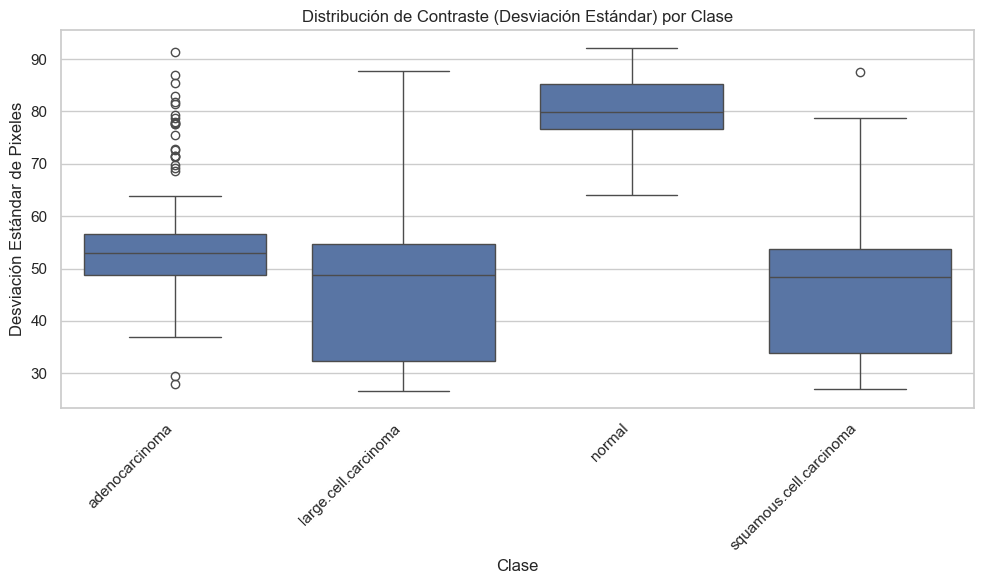

In [42]:
# Histograma de la desviación estándar por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=intensity_df, x="class", y="std")
plt.title("Distribución de Contraste (Desviación Estándar) por Clase")
plt.ylabel("Desviación Estándar de Pixeles")
plt.xlabel("Clase")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

---

Este gráfico muestra la variabilidad en la intensidad de píxeles, lo que se traduce en el **contraste** de las imágenes:

- Normal: Presenta la mayor dispersión de valores (`std ≈ 75–90`), lo que indica imágenes más ricas en variaciones de gris. Esto es consistente con pulmones sanos que contienen más detalles estructurales visibles.
- Clases patológicas (adenocarcinoma, large cell, squamous cell): Tienen menor contraste, con medianas entre `50–55`, lo que puede deberse a la homogeneidad visual de las lesiones.
- Large cell carcinoma: Se destaca por su menor rango de variación (`std ≈ 30–60`), lo que puede indicar lesiones más opacas o compactas.

Las imágenes normales tienden a tener mayor contraste, lo cual puede ser útil para diferenciarlas automáticamente de las patológicas.

---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Baseline</h1>
</div>

## Extracción de características visuales y construcción del clasificador

---
En esta sección se implementará una estrategia de clasificación basada en técnicas clásicas de visión por computadora. Se utilizarán características visuales derivadas del análisis exploratorio de datos realizado previamente, donde se construyeron histogramas y diagramas de caja para evaluar la intensidad y el contraste de las imágenes.

A partir de dicho análisis, se concluyó que las imágenes correspondientes a personas sanas tienden a presentar mayor contraste y mejor iluminación, mientras que las imágenes de pacientes con diagnóstico presentan tonalidades más oscuras.

Estas observaciones motivan la extracción de características estadísticas (como brillo promedio, desviación estándar, contraste, entre otras) que serán utilizadas como variables explicativas en un clasificador Random Forest. Este modelo clásico de machine learning servirá como línea base para comparar con enfoques basados en aprendizaje profundo.

---


In [43]:
def extraer_features(dataset_root, splits, labels, target_size=(224, 224), bins=16):
    datos_por_split = {}

    for split in splits:
        registros = []
        for label in labels:
            folder = dataset_root / split / label
            if not folder.exists():
                continue
            image_files = sorted([f for f in folder.iterdir() if f.is_file()])
            for img_path in tqdm(image_files, desc=f"{split}/{label}"):
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Aspect ratio original
                aspect_ratio = img.shape[1] / img.shape[0]

                # Redimensionar
                img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

                # Features globales
                mean_intensity = np.mean(img_resized)
                std_intensity = np.std(img_resized)
                range_intensity = np.max(img_resized) - np.min(img_resized)

                # Histograma normalizado
                hist = cv2.calcHist([img_resized], [0], None, [bins], [0, 256])
                hist = (hist / hist.sum()).flatten()

                # Armar registro
                features = {
                    "mean_intensity": mean_intensity,
                    "std_intensity": std_intensity,
                    "range_intensity": range_intensity,
                    "aspect_ratio": aspect_ratio,
                    "label": label
                }

                # Agregar bins como columnas separadas
                for i in range(bins):
                    features[f"hist_bin_{i}"] = hist[i]

                registros.append(features)

        # Guardar DataFrame del split
        datos_por_split[split] = pd.DataFrame(registros)

    return datos_por_split.get("train"), datos_por_split.get("valid"), datos_por_split.get("test")

splits = ["train", "valid", "test"]
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

df_train, df_valid, df_test = extraer_features(dataset_root, splits, labels)

test/squamous.cell.carcinoma: 100%|██████████| 90/90 [00:00<00:00, 271.33it/s]


## Entrenamiento del modelo Random Forest

No se encontró un modelo guardado. Entrenando un nuevo modelo...
Modelo guardado como random_forest_baseline_no_optimizado.pkl
Classification Report (F1):

                         precision    recall  f1-score   support

         adenocarcinoma       0.64      0.78      0.71        23
   large.cell.carcinoma       0.69      0.43      0.53        21
                 normal       1.00      0.85      0.92        13
squamous.cell.carcinoma       0.45      0.60      0.51        15

               accuracy                           0.65        72
              macro avg       0.70      0.66      0.67        72
           weighted avg       0.68      0.65      0.65        72

F2 score (ponderado): 0.6497


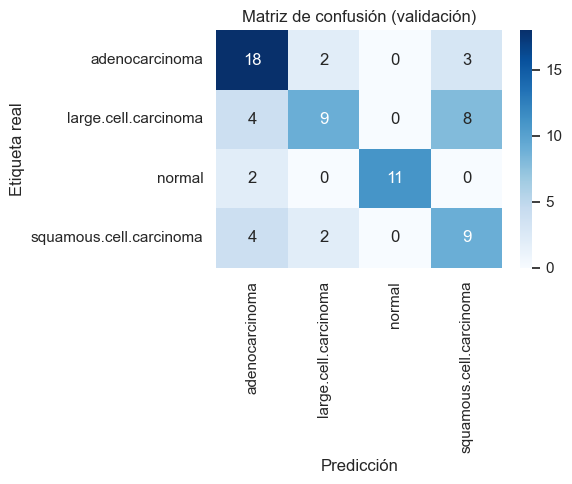

In [44]:
# Si hay un modelo guardado, lo cargamos
if os.path.exists("random_forest_baseline_no_optimizado.pkl"):
    print("Cargando modelo guardado...")
    clf = joblib.load("random_forest_baseline_no_optimizado.pkl")
    print("Modelo cargado correctamente.")
else:
    print("No se encontró un modelo guardado. Entrenando un nuevo modelo...")


    # Codificar etiquetas
    le = LabelEncoder()
    df_train["label_encoded"] = le.fit_transform(df_train["label"])
    df_valid["label_encoded"] = le.transform(df_valid["label"])

    # Separar features y etiquetas
    X_train = df_train.drop(columns=["label", "label_encoded"])
    y_train = df_train["label_encoded"]

    X_valid = df_valid.drop(columns=["label", "label_encoded"])
    y_valid = df_valid["label_encoded"]

    # Entrenar modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predicción
    y_pred = clf.predict(X_valid)
    
    # Guardar modelo en disco
    joblib.dump(clf, "random_forest_baseline_no_optimizado.pkl")
    print("Modelo guardado como random_forest_baseline_no_optimizado.pkl")

# Métricas
print("Classification Report (F1):\n")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

f2 = fbeta_score(y_valid, y_pred, beta=2, average="weighted")
print(f"F2 score (ponderado): {f2:.4f}")



# Matriz de confusión
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de confusión (validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Se entrena un modelo Random Forest utilizando los parámetros por defecto del clasificador. Las etiquetas fueron codificadas con `LabelEncoder` y se utilizaron las características extraídas previamente como variables de entrada. En esta etapa se realiza la predicción sobre el conjunto de validación y se reportan las métricas de desempeño junto con la matriz de confusión.

---

## Evaluación del modelo sobre el conjunto de test

Evaluación en conjunto de test:

                         precision    recall  f1-score   support

         adenocarcinoma       0.40      0.28      0.33       120
   large.cell.carcinoma       0.27      0.78      0.41        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.53      0.18      0.27        90

               accuracy                           0.45       315
              macro avg       0.55      0.56      0.50       315
           weighted avg       0.52      0.45      0.44       315

F2 score (ponderado, test): 0.4344


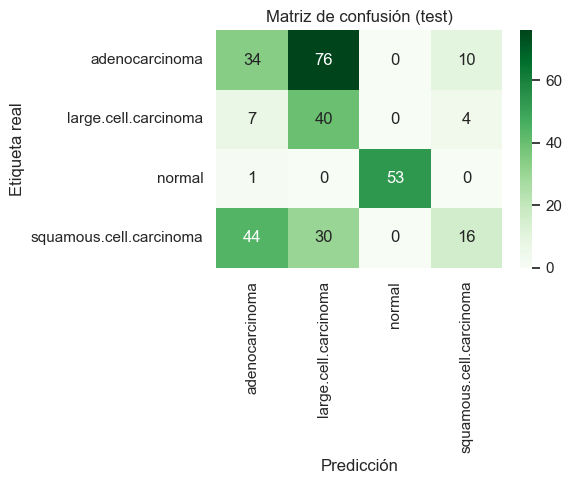

In [45]:
# Codificar etiquetas reales del test (usando el LabelEncoder entrenado)
df_test["label_encoded"] = le.transform(df_test["label"])

# Separar features y etiquetas
X_test = df_test.drop(columns=["label", "label_encoded"])
y_test = df_test["label_encoded"]

# Cargar modelo entrenado
clf = joblib.load("random_forest_baseline_no_optimizado.pkl")

# Predicción
y_pred_test = clf.predict(X_test)

# Reporte
print("Evaluación en conjunto de test:\n")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

f2_test = fbeta_score(y_test, y_pred_test, beta=2, average="weighted")
print(f"F2 score (ponderado, test): {f2_test:.4f}")

# Matriz de confusión
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Matriz de confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Una vez entrenado el modelo sobre los conjuntos `train` y `validación`, se procede a evaluar su desempeño sobre el conjunto de `test`, que no fue utilizado en ninguna etapa previa del entrenamiento.

Se aplican las mismas transformaciones sobre las características y etiquetas y se reportan las métricas de clasificación y la matriz de confusión correspondiente. Esta evaluación permite obtener una estimación más objetiva del rendimiento del modelo ante datos no vistos.

---

## Entrenamiento con búsqueda de hiperparámetros

In [46]:
if os.path.exists("random_forest_baseline_optimizado.pkl"):
    print("Cargando modelo optimizado guardado...")
    best_clf = joblib.load("random_forest_baseline_optimizado.pkl")
    print("Modelo optimizado cargado correctamente.")
    print("Mejores hiperparámetros:", best_clf.get_params())
else:
    print("No se encontró un modelo optimizado guardado. Entrenando un nuevo modelo optimizado...")

    # Separar features y etiquetas (como antes)
    X_train = df_train.drop(columns=["label", "label_encoded"])
    y_train = df_train["label_encoded"]

    # Definir métrica F2 como función para grid search
    f2_scorer = make_scorer(fbeta_score, beta=2, average="weighted")

    # Grilla de hiperparámetros
    param_grid = {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["balanced"] # fuerza a considerar pesos automáticos por clase
    }


    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar búsqueda
    grid_search.fit(X_train, y_train)

    # Mejor modelo
    best_clf = grid_search.best_estimator_
    print("Mejores hiperparámetros:", grid_search.best_params_)
    
    print("Guardando modelo optimizado...")
    # Guardar modelo optimizado
    joblib.dump(best_clf, "random_forest_baseline_optimizado.pkl")
    print("Modelo optimizado guardado como random_forest_baseline_optimizado.pkl")



No se encontró un modelo optimizado guardado. Entrenando un nuevo modelo optimizado...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Guardando modelo optimizado...
Modelo optimizado guardado como random_forest_baseline_optimizado.pkl


Cargando modelo optimizado guardado...
Modelo optimizado cargado correctamente.
Classification Report (F1):

                         precision    recall  f1-score   support

         adenocarcinoma       0.64      0.78      0.71        23
   large.cell.carcinoma       0.69      0.43      0.53        21
                 normal       1.00      0.85      0.92        13
squamous.cell.carcinoma       0.45      0.60      0.51        15

               accuracy                           0.65        72
              macro avg       0.70      0.66      0.67        72
           weighted avg       0.68      0.65      0.65        72

F2 score (ponderado): 0.6497


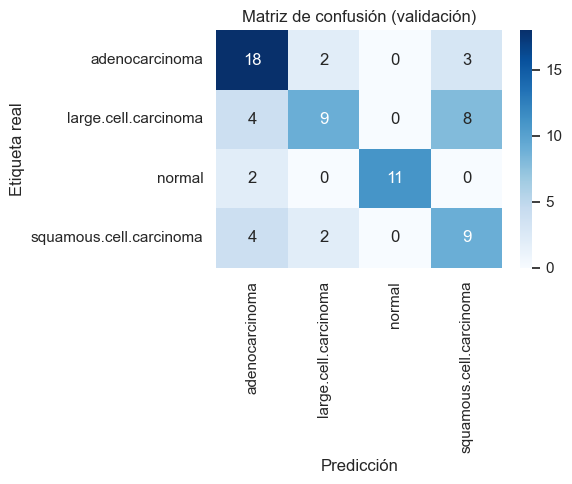

In [47]:

# Si hay un modelo guardado, lo cargamos
if os.path.exists("random_forest_baseline_optimizado.pkl"):
    print("Cargando modelo optimizado guardado...")
    best_clf = joblib.load("random_forest_baseline_optimizado.pkl")
    print("Modelo optimizado cargado correctamente.")
else:
    print("No se encontró un modelo optimizado guardado. Entrenando un nuevo modelo...")


    # Codificar etiquetas
    le = LabelEncoder()
    df_train["label_encoded"] = le.fit_transform(df_train["label"])
    df_valid["label_encoded"] = le.transform(df_valid["label"])

    # Separar features y etiquetas
    X_train = df_train.drop(columns=["label", "label_encoded"])
    y_train = df_train["label_encoded"]

    X_valid = df_valid.drop(columns=["label", "label_encoded"])
    y_valid = df_valid["label_encoded"]

    # Entrenar modelo optimizado
    
    best_clf.fit(X_train, y_train)

    # Predicción
    y_pred = best_clf.predict(X_valid)
    
    # Guardar modelo en disco
    joblib.dump(best_clf, "random_forest_baseline_optimizado.pkl")
    print("Modelo guardado como random_forest_baseline_optimizado.pkl")

# Métricas
print("Classification Report (F1):\n")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

f2 = fbeta_score(y_valid, y_pred, beta=2, average="weighted")
print(f"F2 score (ponderado): {f2:.4f}")



# Matriz de confusión
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de confusión (validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Se entrena un modelo Random Forest aplicando búsqueda de hiperparámetros con `GridSearchCV`. El procedimiento consiste en explorar distintas combinaciones de parámetros como `n_estimators`, `max_depth` y `criterion`, evaluando el desempeño mediante validación cruzada.

Se incluye además la opción `class_weight='balanced'` para compensar el desbalance de clases ajustando los pesos según la frecuencia relativa de cada clase.

Una vez finalizada la búsqueda, se entrena el mejor modelo sobre el conjunto de entrenamiento completo.

---

## Evaluación del modelo optimizado

Evaluación en conjunto de test:

                         precision    recall  f1-score   support

         adenocarcinoma       0.39      0.32      0.35       120
   large.cell.carcinoma       0.27      0.73      0.39        51
                 normal       1.00      0.96      0.98        54
squamous.cell.carcinoma       0.52      0.17      0.25        90

               accuracy                           0.45       315
              macro avg       0.54      0.54      0.49       315
           weighted avg       0.51      0.45      0.44       315

F2 score (ponderado, test): 0.4347


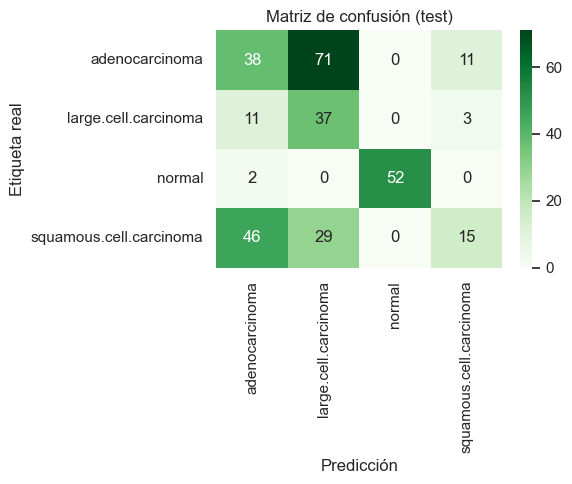

In [48]:
# Codificar etiquetas reales del test (usando el LabelEncoder entrenado)
df_test["label_encoded"] = le.transform(df_test["label"])

# Separar features y etiquetas
X_test = df_test.drop(columns=["label", "label_encoded"])
y_test = df_test["label_encoded"]

# Cargar modelo entrenado
best_clf = joblib.load("random_forest_baseline_optimizado.pkl")

# Predicción
y_pred_test = best_clf.predict(X_test)

# Reporte
print("Evaluación en conjunto de test:\n")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

f2_test = fbeta_score(y_test, y_pred_test, beta=2, average="weighted")
print(f"F2 score (ponderado, test): {f2_test:.4f}")

# Matriz de confusión
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Matriz de confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Finalizado el entrenamiento del modelo con los mejores hiperparámetros encontrados, se evalúa su desempeño sobre el conjunto de validación.

Se reportan las métricas de clasificación (precisión, recall, F1-score) y la matriz de confusión, lo que permite comparar los resultados obtenidos frente al modelo base entrenado con los parámetros por defecto.

---

## Análisis de resultados

---

El modelo Random Forest basado en características visuales extraídas manualmente logró un desempeño aceptable en validación (F₂ = 0.66), aunque presentó una caída importante en el conjunto de test (F₂ = 0.43), lo que indica una capacidad limitada de generalización.

El análisis de errores revela que el modelo distingue con mayor claridad la clase “normal”, pero muestra dificultades para diferenciar entre los distintos subtipos de enfermedad pulmonar, evidenciando confusión entre clases patológicas.

El modelo final utilizó los mejores hiperparámetros encontrados mediante búsqueda en grilla, incluyendo una profundidad máxima moderada y el ajuste de pesos por clase (`class_weight='balanced'`).

Este comportamiento sugiere que las características estadísticas extraídas (intensidad, contraste, etc.) no son suficientes para capturar la complejidad visual presente en las imágenes. Por ello, se propone avanzar hacia un enfoque basado en redes neuronales convolucionales preentrenadas mediante *transfer learning*, que permitirán extraer representaciones más descriptivas y discriminativas, especialmente útiles para clasificar correctamente las clases con mayor solapamiento visual.

---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Conclusiones parciales y próximos pasos</h1>
</div>

---

En una primera versión de este trabajo, se abordó directamente la clasificación de imágenes mediante redes neuronales convolucionales preentrenadas sobre datasets genéricos de gran escala, como *ImageNet* (con más de 1.4 millones de imágenes). Esta elección resultó inadecuada debido a dos limitaciones centrales:

- *ImageNet* no está compuesto por imágenes médicas, lo cual debilita la transferencia de conocimiento hacia el dominio clínico.
- El conjunto de datos local disponible contiene apenas ~1000 imágenes, lo que vuelve insuficiente el fine-tuning profundo sobre modelos tan complejos.

Frente a estas observaciones, se decidió replantear el enfoque del proyecto. A partir de allí se propuso incorporar una línea base más robusta, desarrollada con técnicas clásicas de visión por computadora y un modelo `RandomForestClassifier` sobre características manuales extraídas del EDA.

Este cambio metodológico permitió no solo establecer un punto de comparación más realista, sino también valorar los límites de las estrategias clásicas. El análisis evidenció que, aunque el modelo clásico logra detectar adecuadamente casos normales, no resulta suficiente para diferenciar entre subtipos patológicos.

A partir de este aprendizaje, los próximos pasos retoman el uso de redes convolucionales, ahora con mayor justificación técnica y con objetivos más claros:

- Implementar redes convolucionales preentrenadas sobre datasets médicos, ajustando sus capas finales mediante *fine-tuning*.
- Aplicar técnicas de aumento de datos moderadas (rotaciones, volteos) para mitigar el bajo volumen del dataset sin distorsionar la naturaleza de las imágenes médicas.
- Evaluar el rendimiento utilizando la métrica F-beta (con β=2), que prioriza la reducción de falsos negativos por su relevancia clínica.
- Realizar inferencia sobre el conjunto de test y análisis detallado por clase.
- Generar gráficos de evolución de métricas (`loss`, `accuracy`, `F-beta`) durante entrenamiento y validación.
- Explorar nuevas estrategias de mejora como reconfiguración de hiperparámetros, técnicas avanzadas de balanceo de clases y ajustes específicos por arquitectura.

Este proceso de iteración y reformulación constituye un aprendizaje clave del trabajo, al poner en evidencia la importancia de una línea base bien construida y la necesidad de adaptar las herramientas de aprendizaje profundo a las particularidades del dominio médico.

---


